In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats
import warnings
from scipy.ndimage import gaussian_filter1d
import seaborn as sns

warnings.filterwarnings('ignore')

In [2]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [15]:
def get_results(session, model, mode, alpha): 
    res_name = f"{session}_glm_{EVENT}_{mode}_{INTERVAL_SIZE}_{model}_maxfeat.pickle"
    res = pd.read_pickle(os.path.join(OUTPUT_DIR, res_name))
    res["session"] = session
    res["PseudoUnitID"] = int(session) * 100 + res.UnitID

    shuffle_name = f"{session}_glm_{EVENT}_{mode}_{INTERVAL_SIZE}_{model}_maxfeat_shuffles.pickle"
    shuffles = pd.read_pickle(os.path.join(OUTPUT_DIR, shuffle_name))
    # sig_bounds = shuffles.groupby("split_idx").apply(lambda group: glm_utils.calculate_sig_stats(group, alpha, 1, "score")).reset_index()
    sig_bounds = glm_utils.calculate_sig_stats(shuffles, alpha, 1, "score")

    merged = pd.merge(res, sig_bounds, on=["UnitID"])
    return merged
# sig = glm_utils.calculate_sig_stats(shuffles, )
# return res
# glm_res = pd.concat(sessions.apply(lambda x: get_agg_glm_res(x.session_name), axis=1).values)

In [16]:
num_bins = 10

def plot_things(unit, glm_res, norm_mode, feats_of_interest=[]):
    unit_res = glm_res[glm_res.PseudoUnitID == unit].iloc[0]
    session = unit_res.session_x
    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber")
    beh = behavioral_utils.get_feature_values_per_session(session, beh)
    beh = behavioral_utils.get_max_feature_value(beh, num_bins)


    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{NUM_BINS_SMOOTH}_smooth.pickle"
    frs = pd.read_pickle(fr_path)
    frs = frs[frs.UnitID == unit_res.UnitID_x]
    agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
    agg = pd.merge(beh[["TrialNumber", "BlockNumber", "CurrentRule", "MaxValueBin", "MaxValue"]], agg, on="TrialNumber")
    agg = spike_utils.zscore_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)
    agg = spike_utils.mean_sub_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)

    beh = behavioral_utils.filter_blocks_by_rule_occurence(beh, 2)
    beh = behavioral_utils.filter_max_feat_correct(beh)

    sub_agg = agg[agg.TrialNumber.isin(beh.TrialNumber)]

    rename_map = {f"{feat}_coef": feat for feat in FEATURES}
    unit_df = unit_res.to_frame().T
    unit_df = unit_df.rename(columns=rename_map)
    melted = pd.melt(unit_df, value_vars=FEATURES, var_name="feature", value_name="coef")

    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    ax = axs[0, 0]
    visualization_utils.plot_bars_by_cat(melted, "coef", "feature", ax, order=FEATURES)
    ax.set_title(f"{unit}: {unit_res.structure_level2}, R^2: {unit_res.score:.3f}")

    # ax = axs[1]
    # visualization_utils.plot_bars_by_cat(agg, "ZFiringRate", "CurrentRule", ax, order=FEATURES)
    # ax.set_title("ZScore")

    ax = axs[1, 0]
    visualization_utils.plot_bars_by_cat(sub_agg, norm_mode, "CurrentRule", ax, order=FEATURES)
    ax.set_title(norm_mode)

    ax = axs[0, 1]
    visualization_utils.plot_mean_sterrs_by_bin(agg, norm_mode, "MaxValueBin", ax, unit_res.PseudoUnitID, num_bins)
    # visualization_utils.plot_mean_sterrs_by_block_pos(beh, "MaxValue", ax, row.PseudoUnitID, num_block_bins)
    ax.set_xlabel("Max Value Bin")
    ax.set_ylabel("Mean firing in inter-trial")
    # ax.set_title(f"{unit_res.structure_level2}: {unit_res.PseudoUnitID}")

    ax = axs[1, 1]
    slope, intercept, r_value, p_value, std_err = stats.linregress(agg["MaxValue"], agg[norm_mode])
    ax.scatter(agg["MaxValue"], agg[norm_mode], alpha=0.3, color="black")
    for feat in feats_of_interest:
        feat_idx = FEATURES.index(feat)
        # color = sns.color_palette("husl", 12)[feat_idx]
        feat_agg = sub_agg[sub_agg.CurrentRule == feat]
        ax.scatter(feat_agg["MaxValue"], feat_agg[norm_mode], alpha=1, label=feat)
    ax.legend()

    ax.plot(agg["MaxValue"], agg["MaxValue"] * slope + intercept)
    ax.set_title(f"Cor w Max Value: r: {r_value:.3f}, p: {p_value:.3E}")
    ax.set_xlabel("Max Value Bin")
    ax.set_ylabel("Mean firing in inter-trial")

    fig.tight_layout()

### Summary for using Mean Subtrated FRs: 
- 52 significant units (alpha of 0.05), fairly low r^2s
- Many in lPFC, some in ventral Pallium, ITC

In [17]:
model = "LinearNoInt"
mode = "MeanSubFiringRate"
alpha = 0.05

glm_res = pd.concat(sessions.apply(lambda x: get_results(x.session_name, model, mode, alpha), axis=1).values)
positions = spike_utils.get_unit_positions(sessions)
glm_res = pd.merge(positions, glm_res, on="PseudoUnitID")

In [18]:
good_reses = glm_res[(glm_res.score > glm_res.sig_bound)]
good_reses = good_reses.sort_values(by="score", ascending=False)

In [19]:
good_reses.groupby("session_x").PseudoUnitID.nunique()

session_x
20180705         2
20180709         4
201807250001     2
20180801        12
20180802         3
20180803         7
20180808         3
20180910         1
20180912         2
20180918         1
20180920         1
20180924         2
20180928         3
20181002         1
20181003         4
20181004         1
20181005         1
20181008         1
20181009         1
Name: PseudoUnitID, dtype: int64

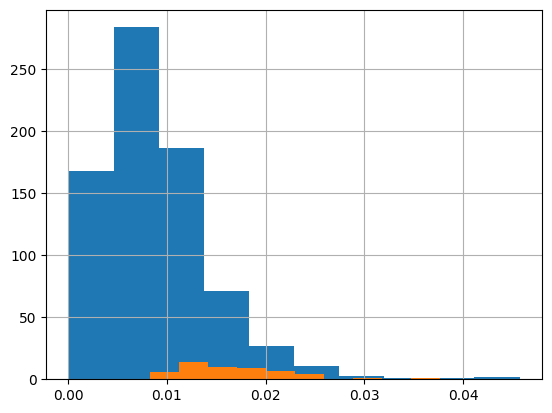

In [11]:
ax = glm_res[glm_res.PseudoUnitID != 2018100106].score.hist()
good_reses.score.hist(ax=ax)
good_units_mean_sub = good_reses.PseudoUnitID.unique()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

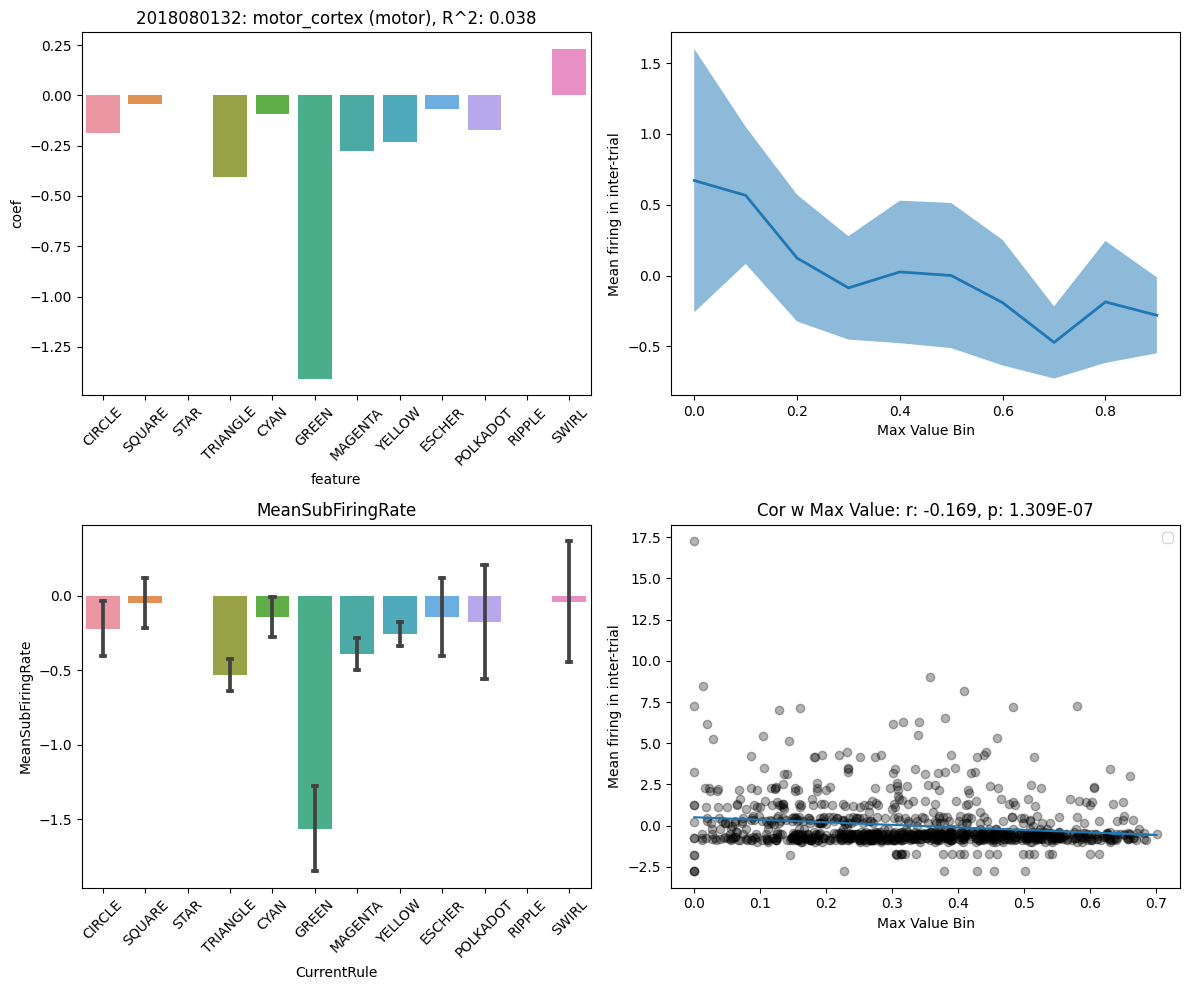

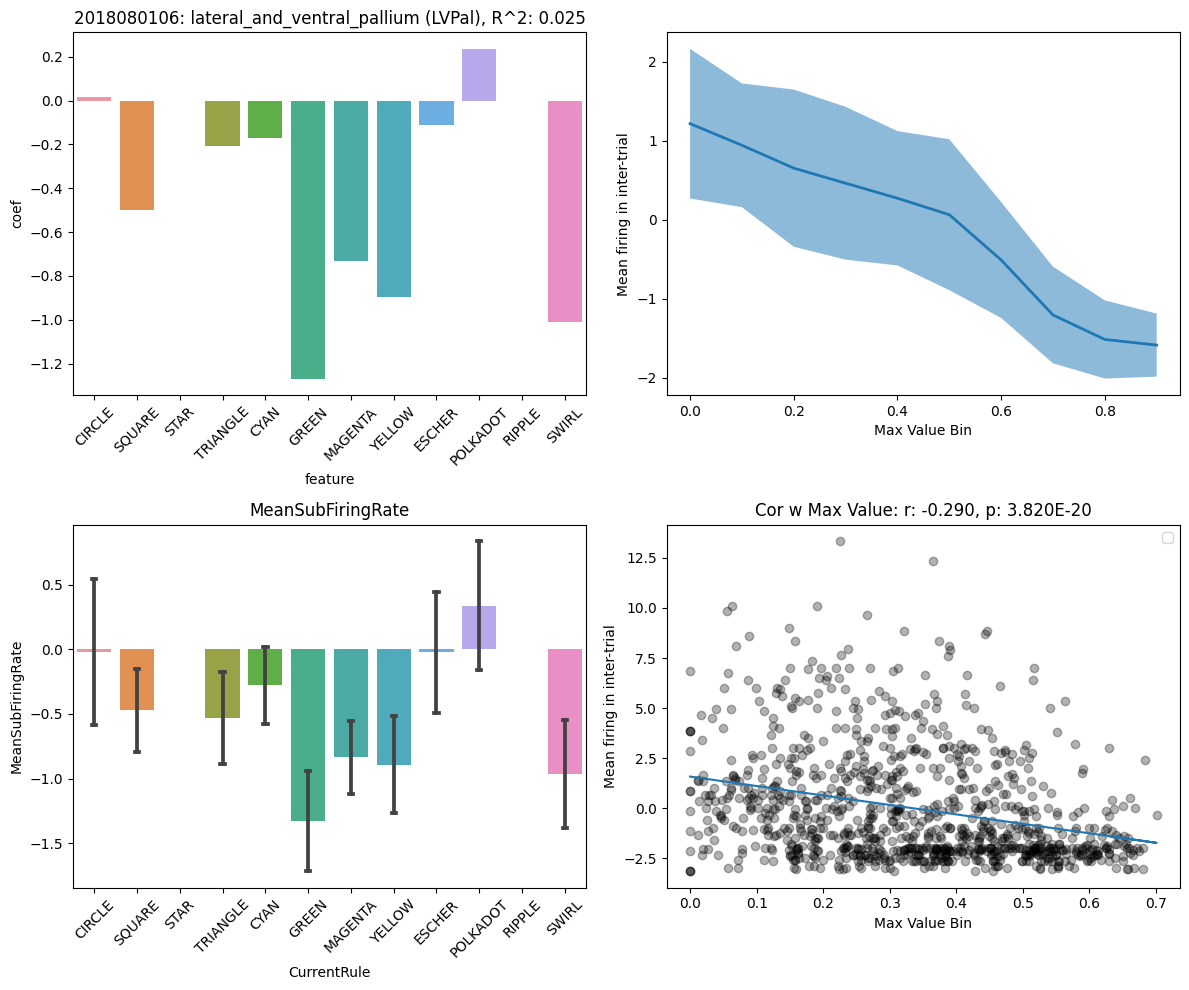

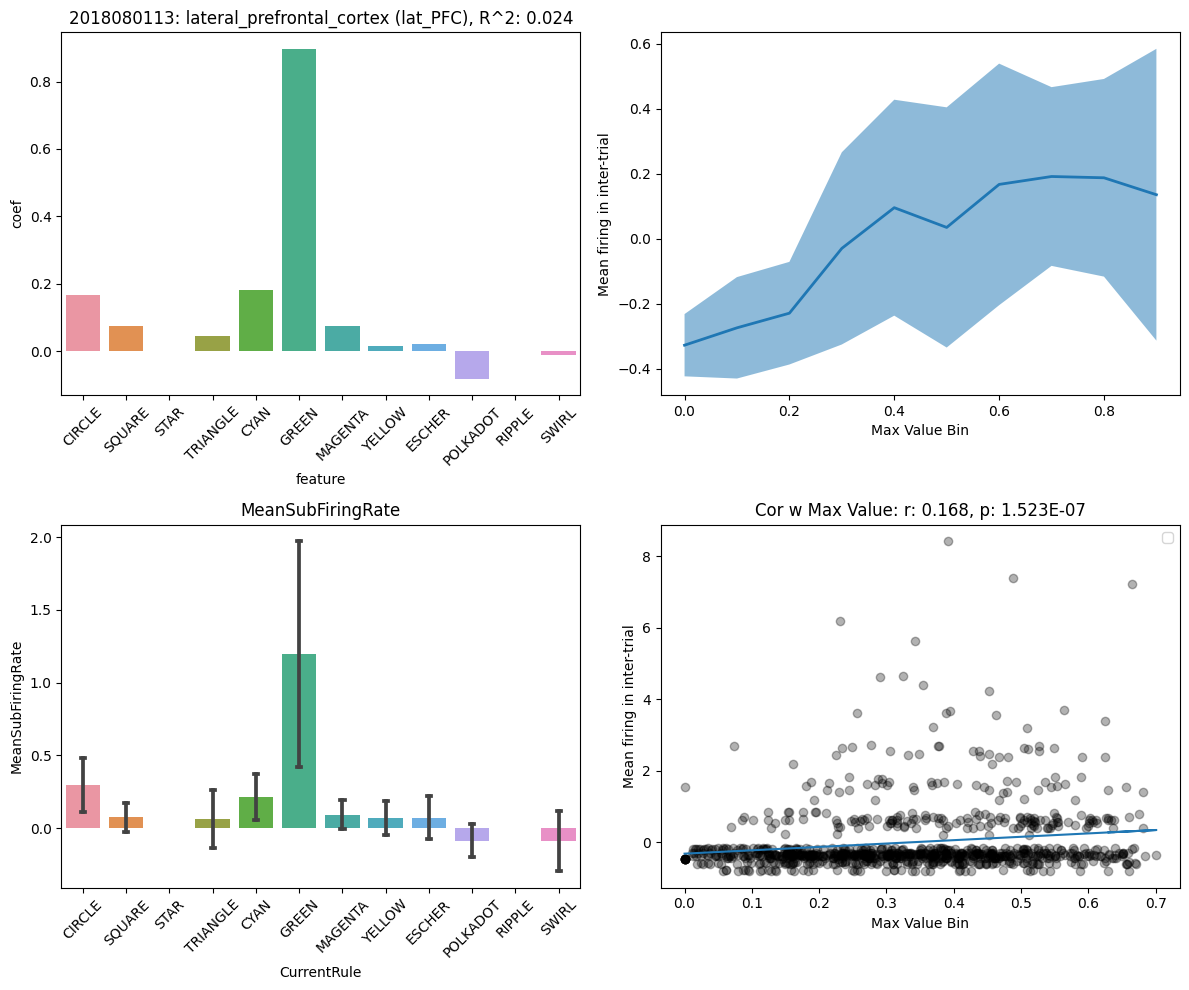

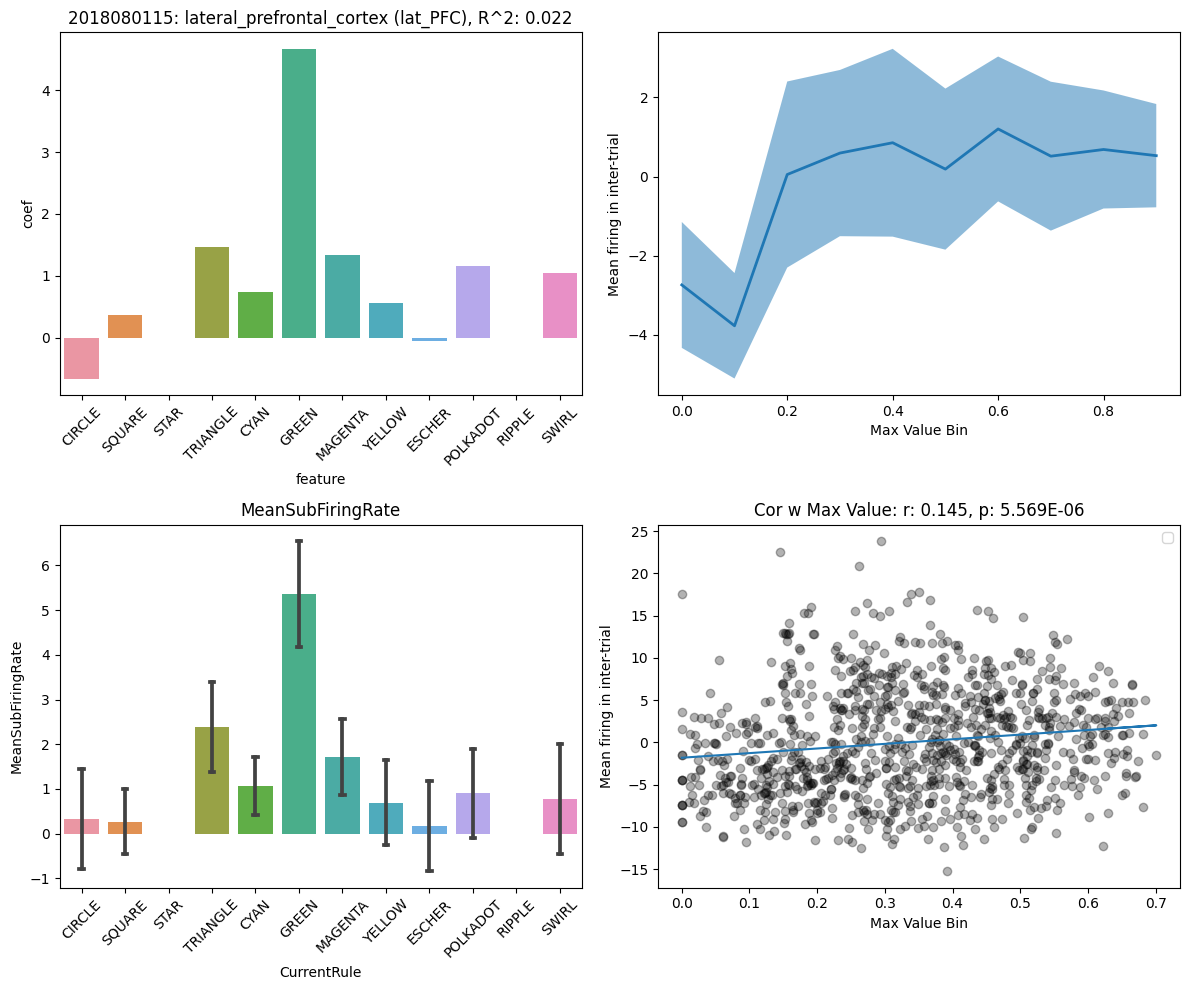

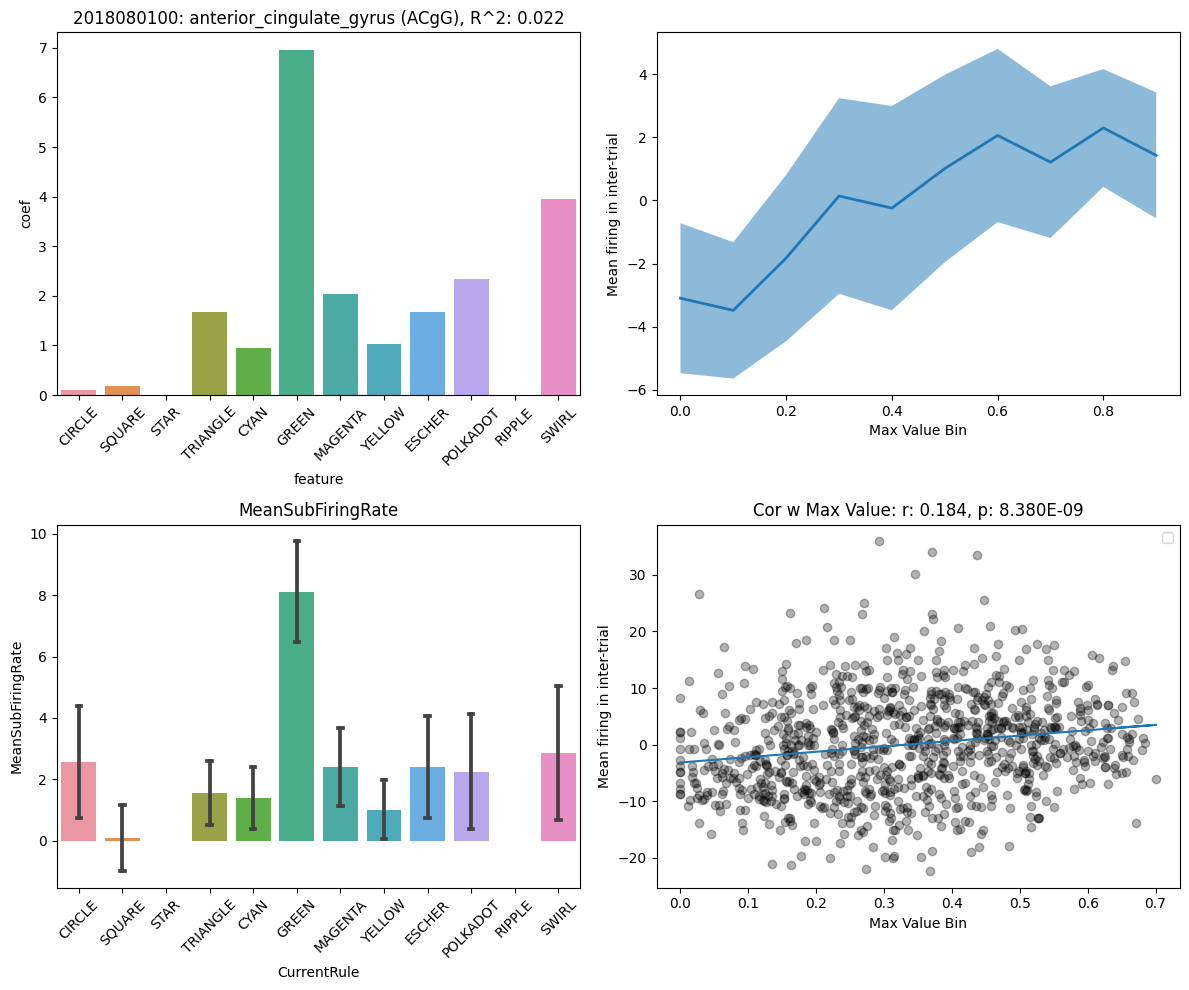

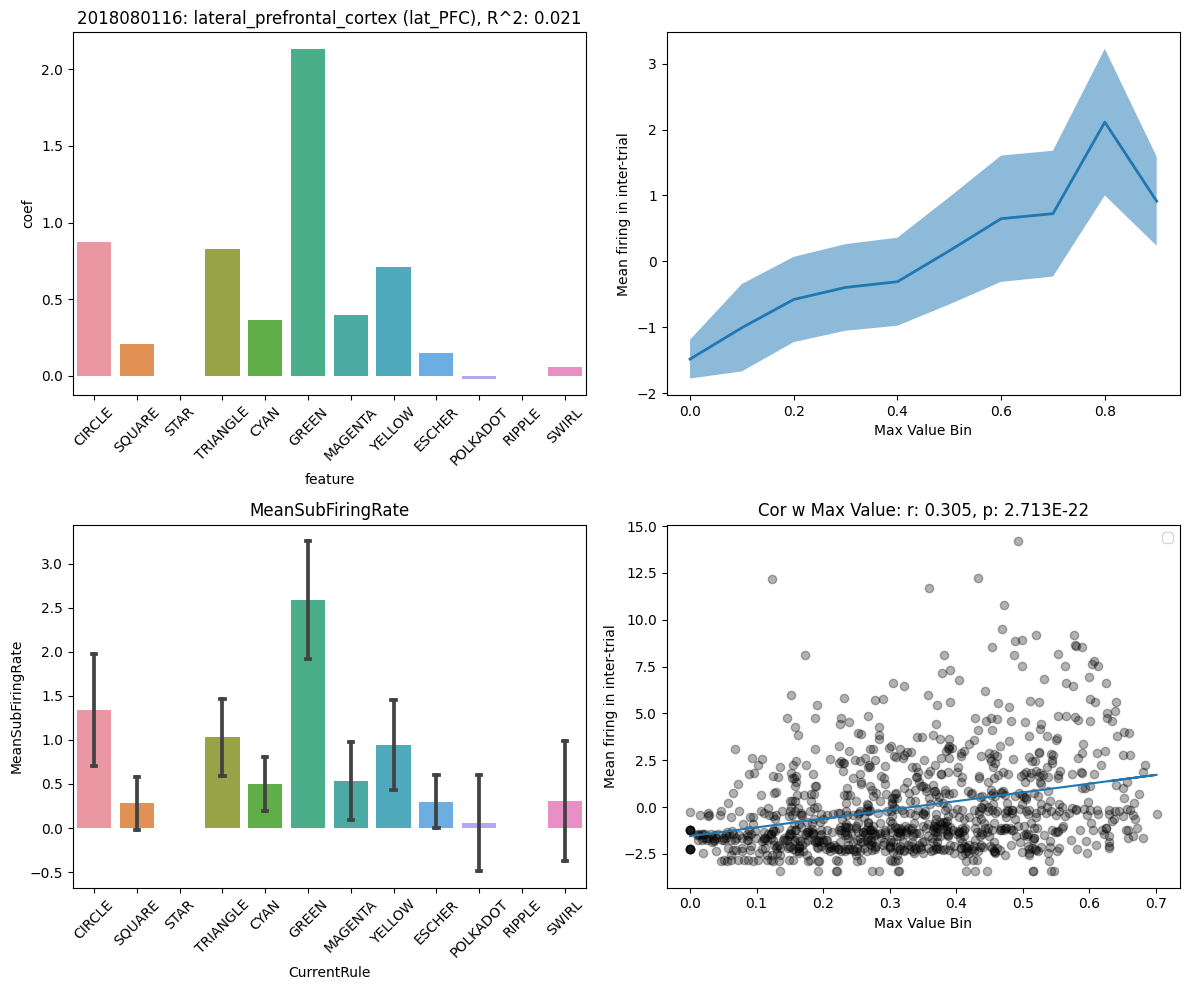

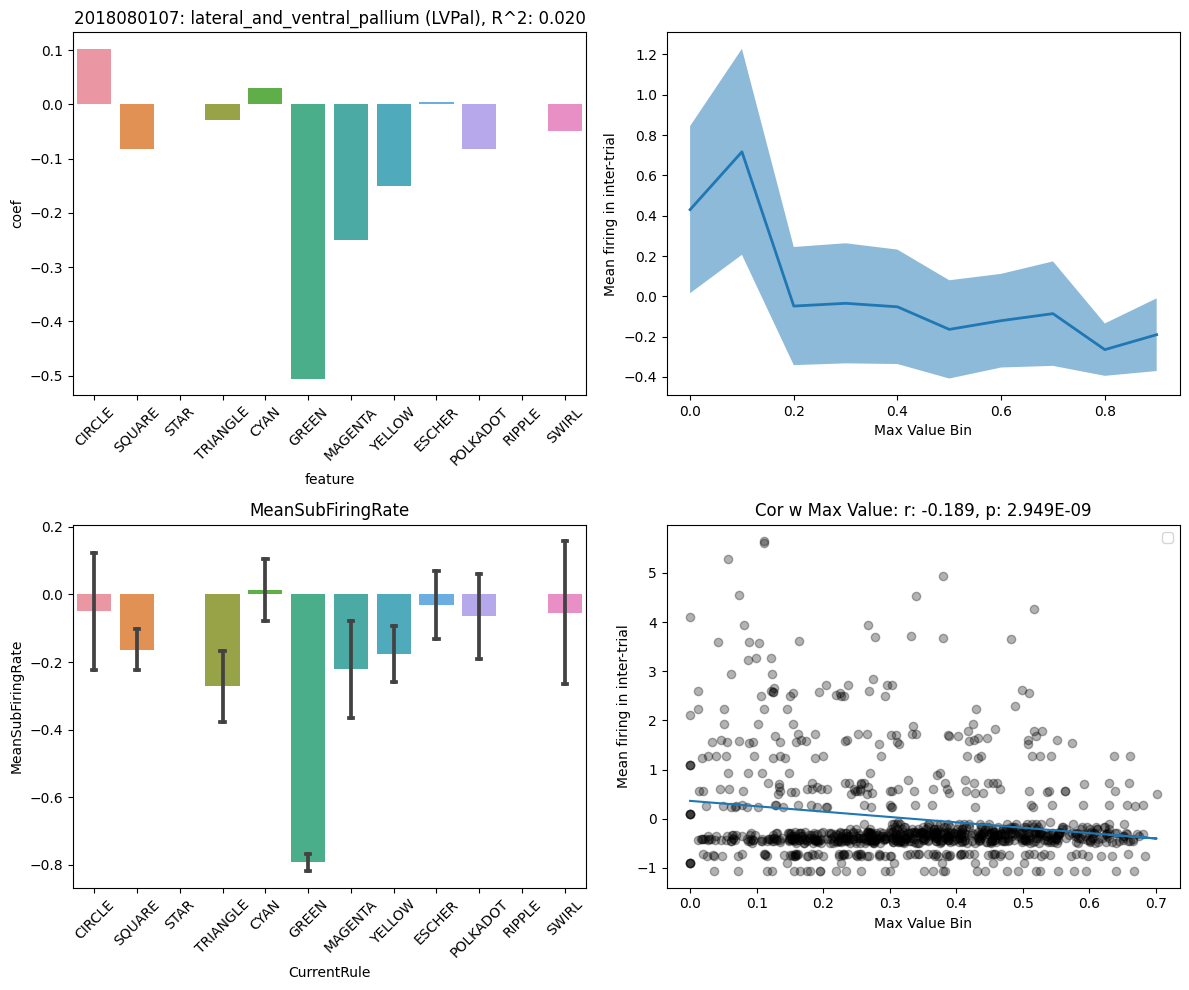

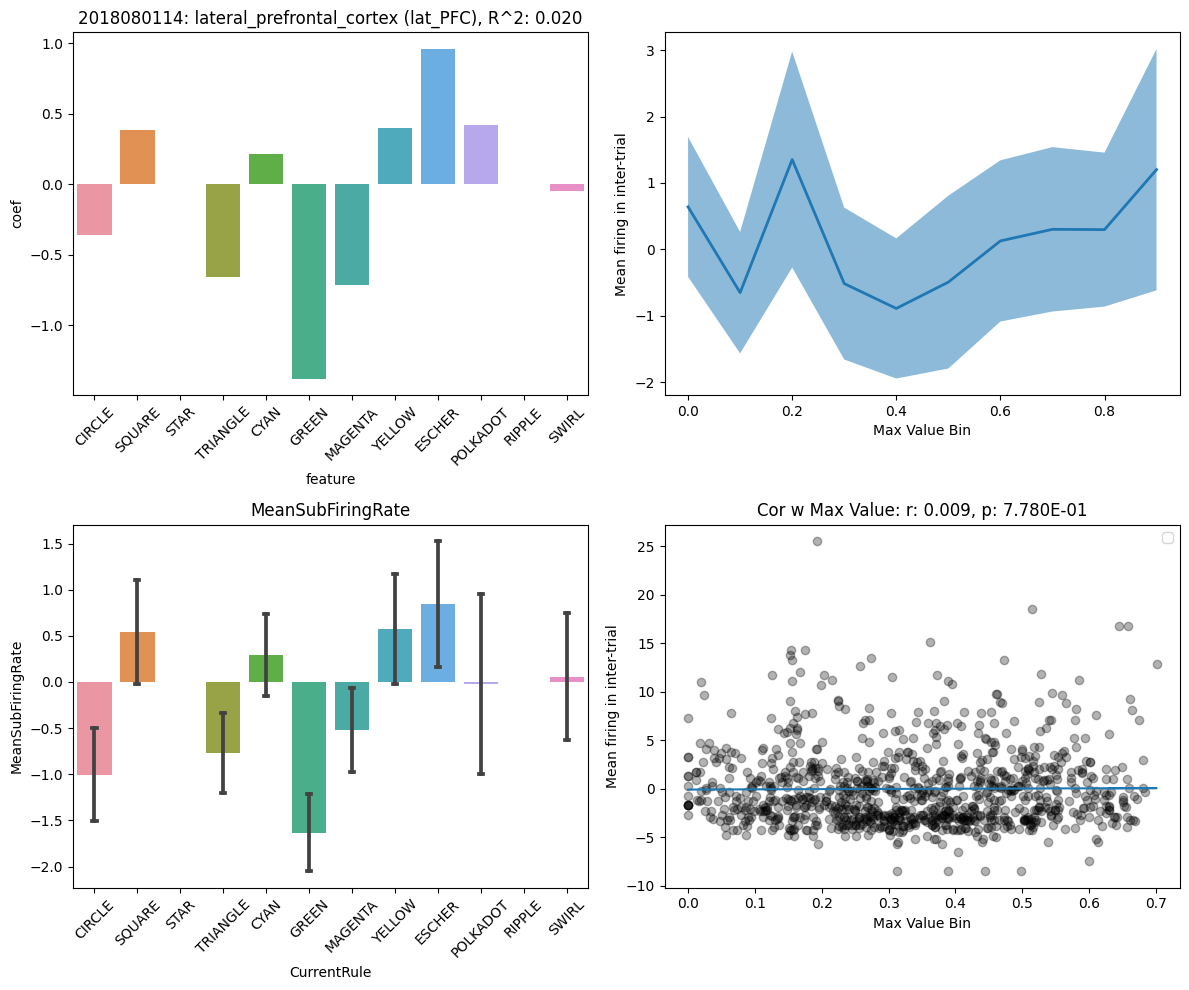

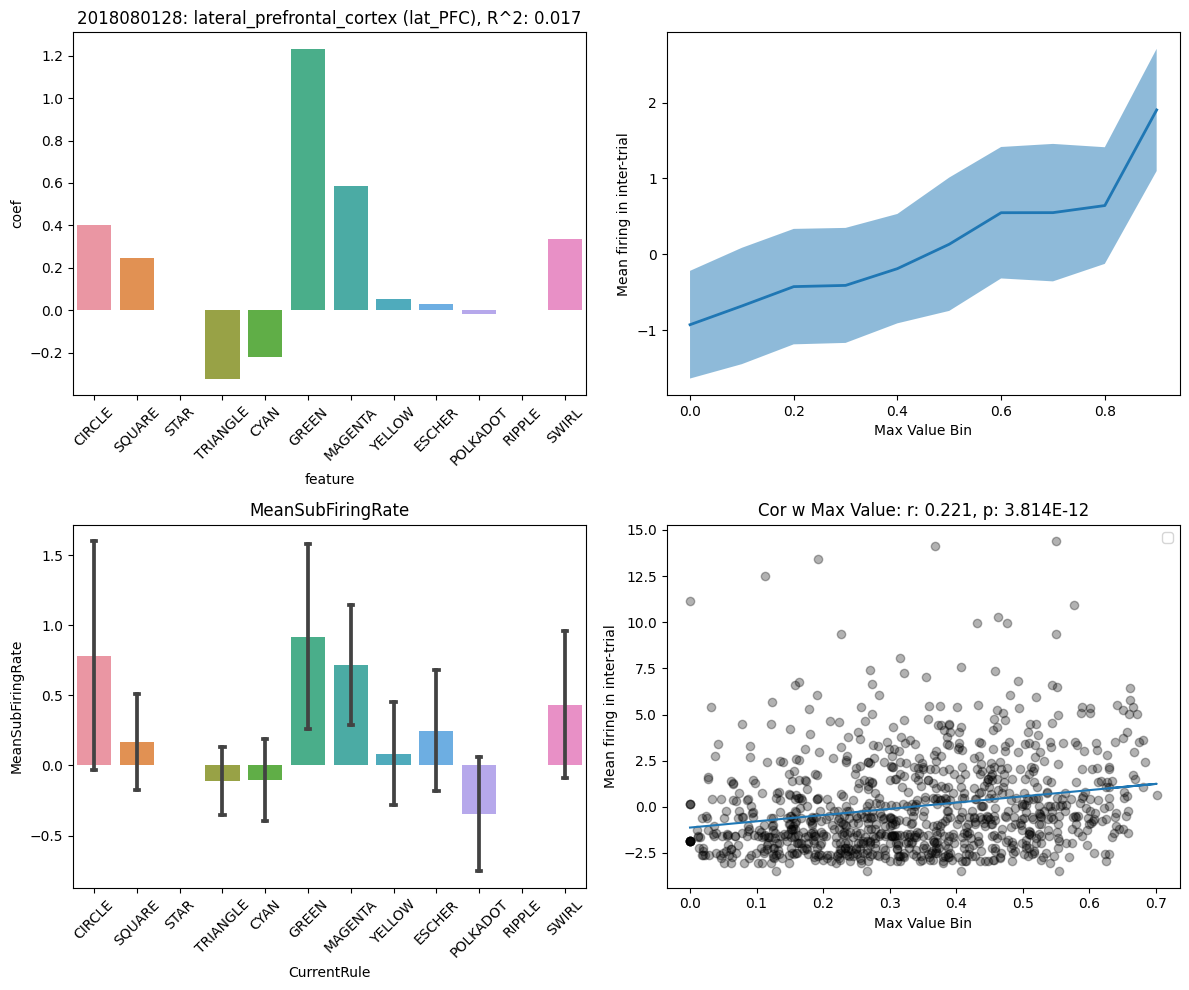

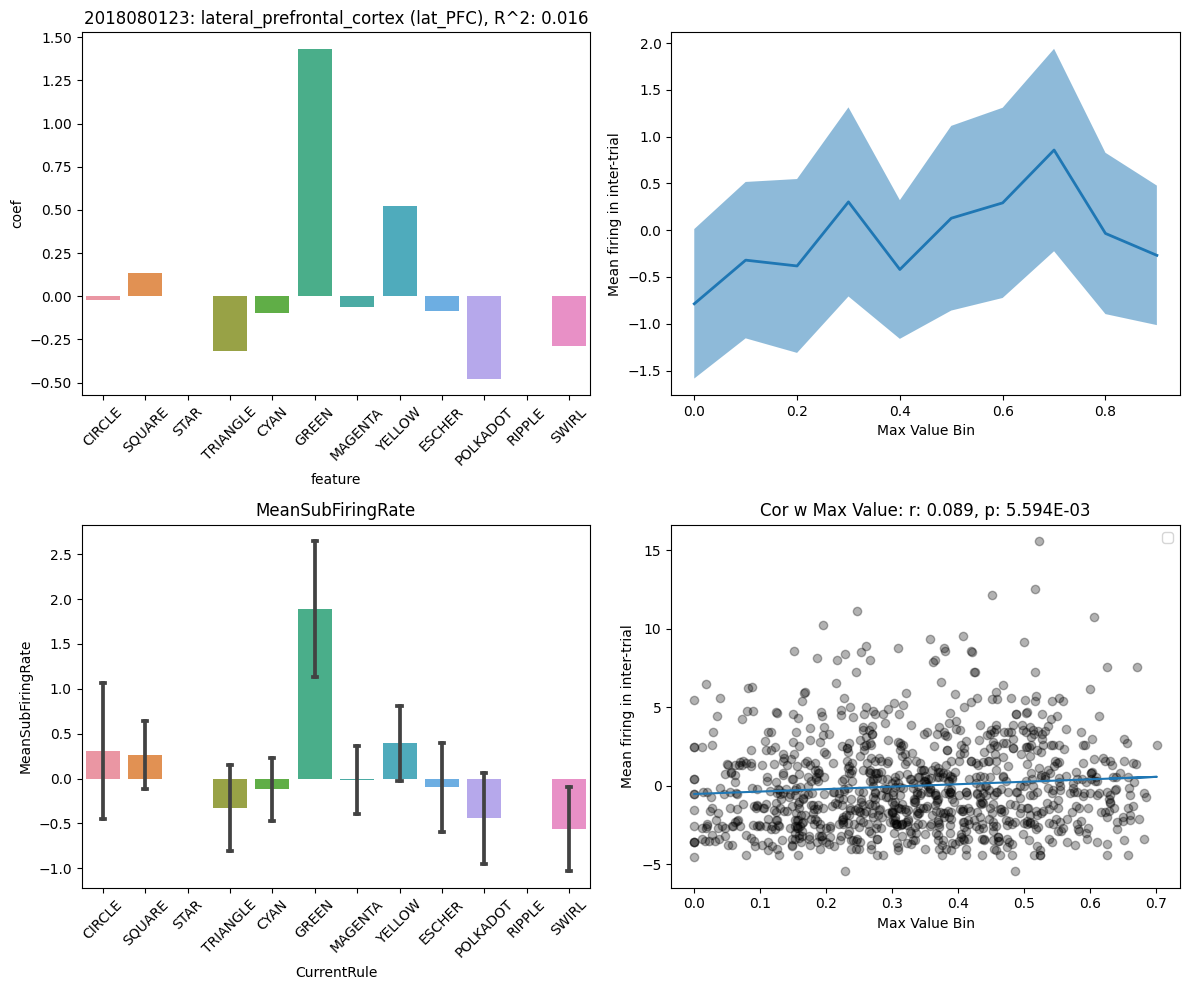

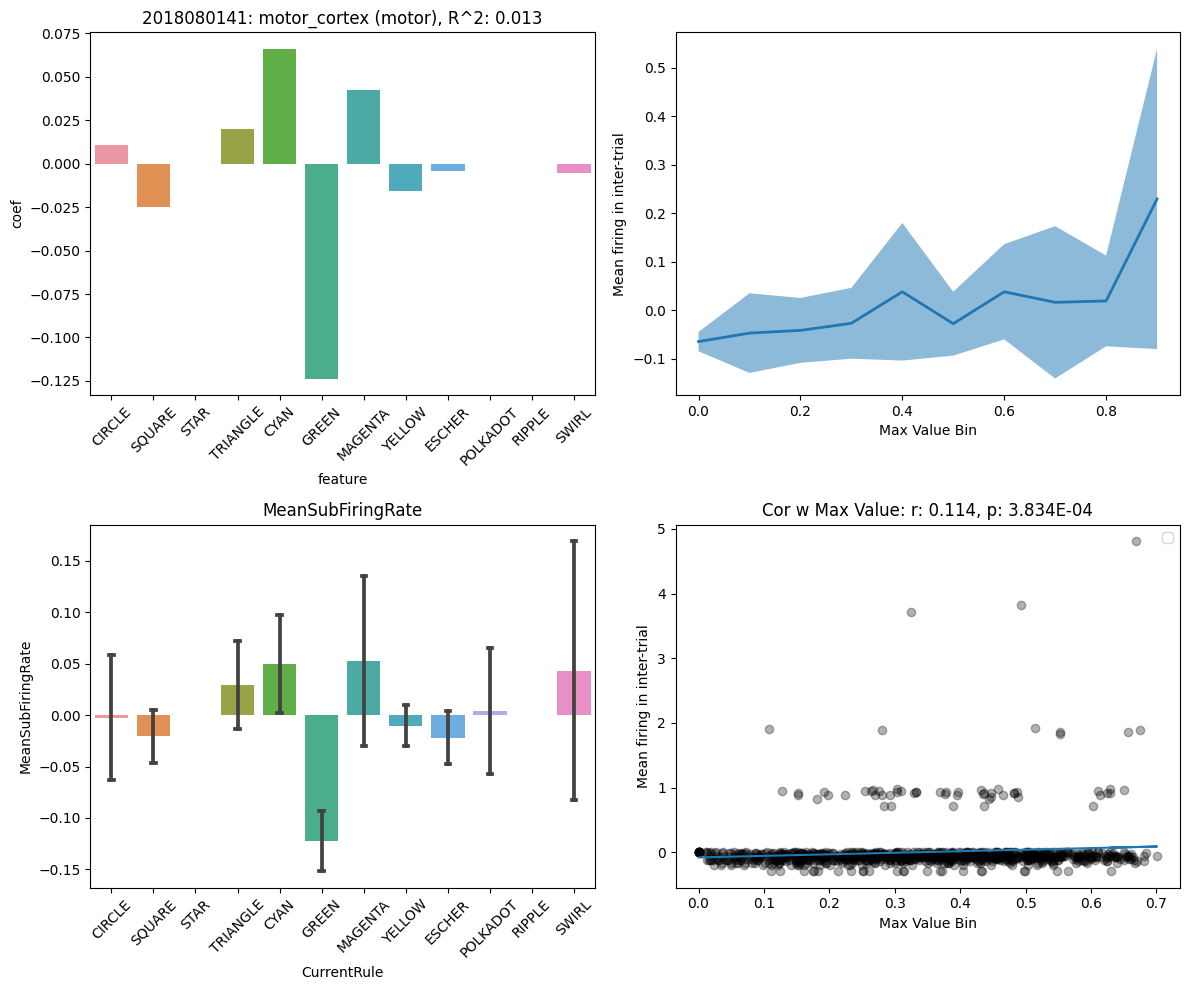

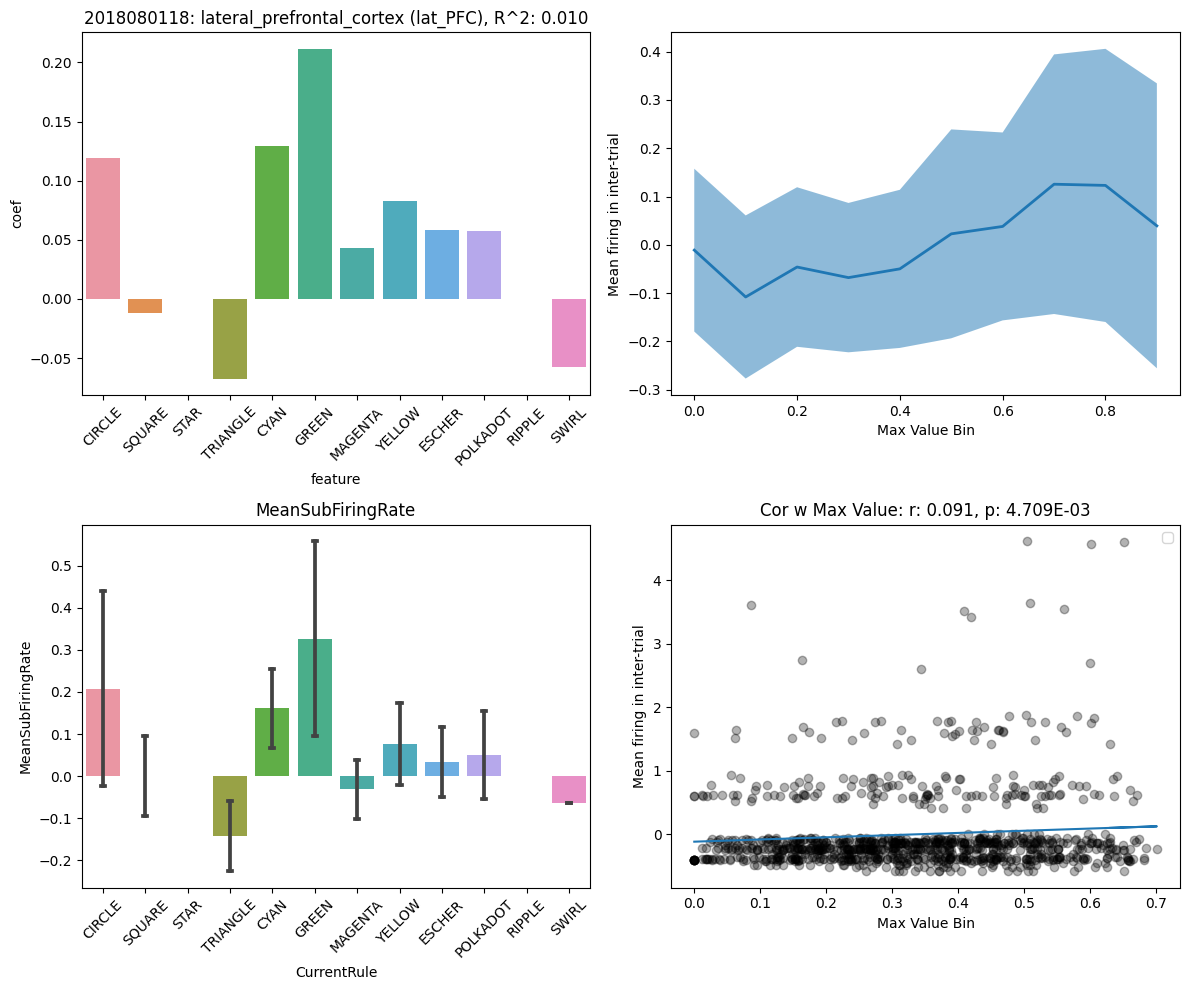

In [20]:
# for unit in [2018091204]:
# reg_units = good_reses[good_reses.structure_level2 == "lateral_and_ventral_pallium (LVPal)"]
# for unit in reg_units.PseudoUnitID.unique():
# for unit in good_reses[good_reses.session_x == "20180803"].PseudoUnitID.unique():
# feats_of_interest = [["GREEN", "SWIRL"], ["POLKADOT", "CYAN"], ["GREEN", "POLKADOT"], ["GREEN", "POLKADOT"], ["CIRCLE", "TRIANGLE"]]
# for i, unit in enumerate(good_reses.sort_values(by="score", ascending=False)[:5].PseudoUnitID.unique()):
#     plot_things(unit, glm_res, mode, feats_of_interest[i])

for i, unit in enumerate(good_reses[good_reses.session_x == "20180801"].PseudoUnitID.unique()):
    plot_things(unit, glm_res, mode)


### Now look at non-normed firing rate GLMs, are there any differences?
- 31 units, in general seems to have higher score
- only 7 units shared between regular FR and mean sub FR good units


In [6]:
model = "LinearNoInt"
mode = "FiringRate"
alpha = 0.05

glm_res = pd.concat(sessions.apply(lambda x: get_results(x.session_name, model, mode, alpha), axis=1).values)
positions = spike_utils.get_unit_positions(sessions)
glm_res = pd.merge(positions, glm_res, on="PseudoUnitID")

In [7]:
good_reses = glm_res[(glm_res.score > glm_res.sig_bound)]
good_reses = good_reses.sort_values(by="score", ascending=False)

<Axes: >

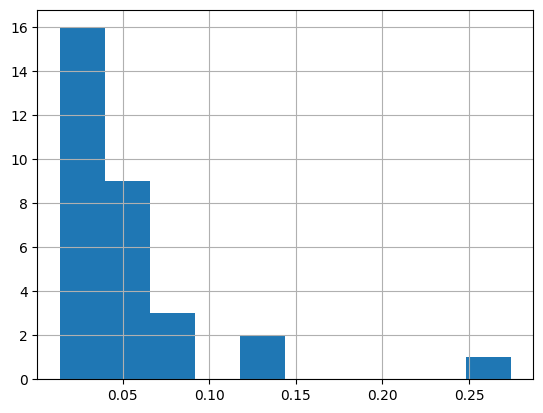

In [8]:
good_reses.score.hist()

In [9]:
good_reses.groupby("structure_level2").PseudoUnitID.nunique()

structure_level2
amygdala (Amy)                            3
anterior_cingulate_gyrus (ACgG)           2
basal_ganglia (BG)                        3
extrastriate_visual_areas_2-4 (V2-V4)     1
inferior_temporal_cortex (ITC)            6
lateral_and_ventral_pallium (LVPal)       2
lateral_prefrontal_cortex (lat_PFC)      10
orbital_frontal_cortex (OFC)              1
superior_parietal_lobule (SPL)            2
thalamus (Thal)                           1
Name: PseudoUnitID, dtype: int64

In [10]:
shared = good_reses[good_reses.PseudoUnitID.isin(good_units_mean_sub)]

NameError: name 'good_units_mean_sub' is not defined

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


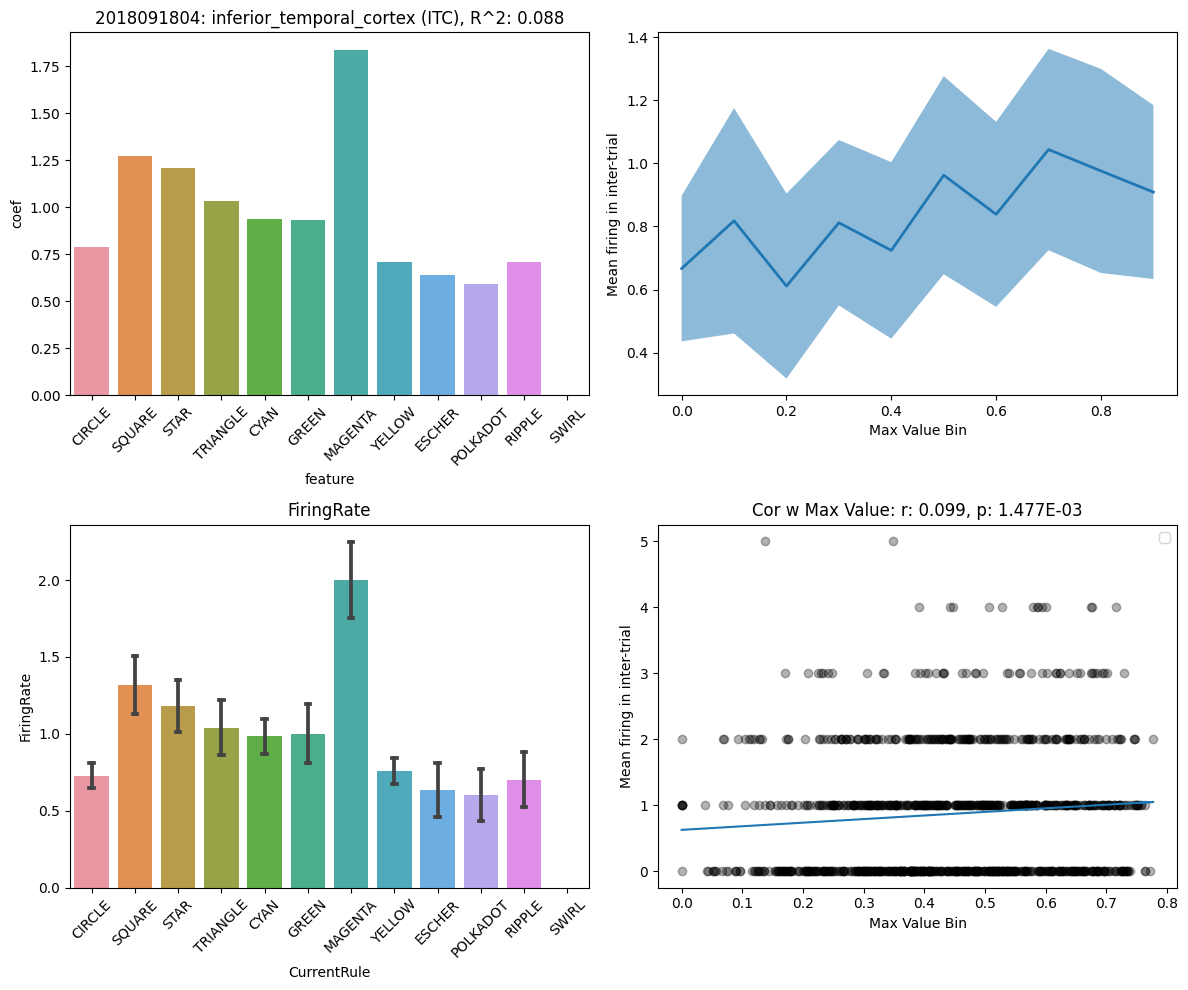

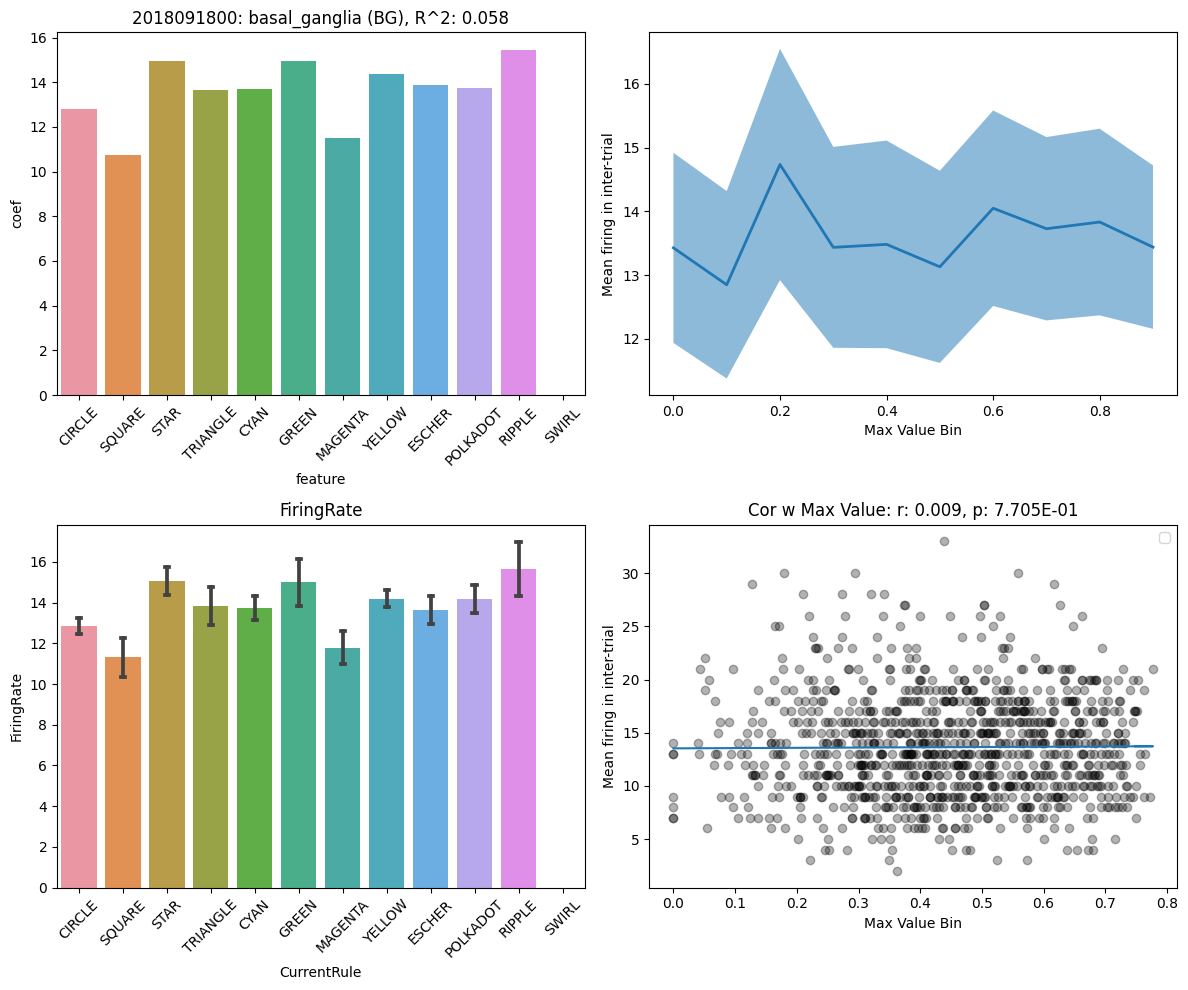

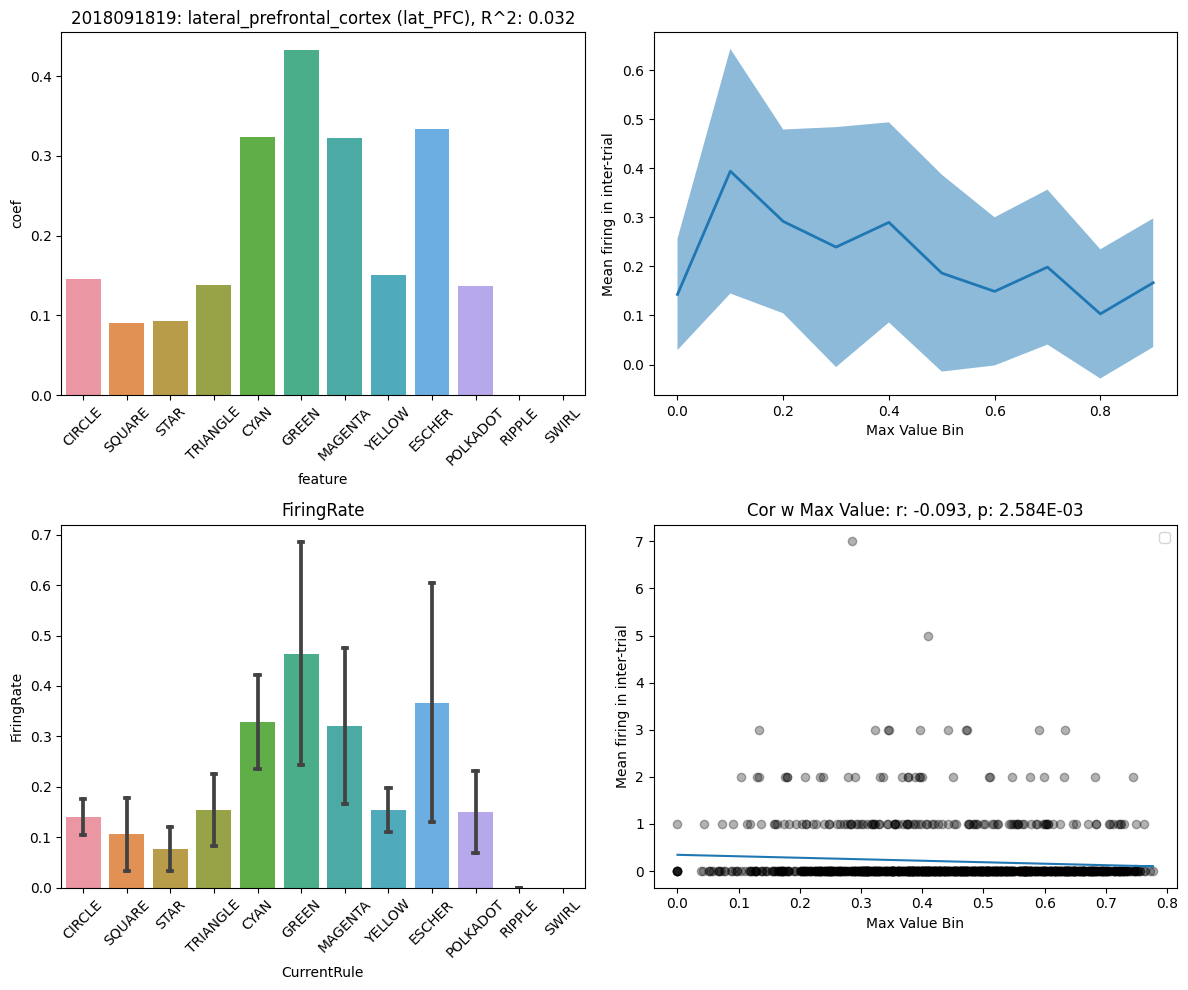

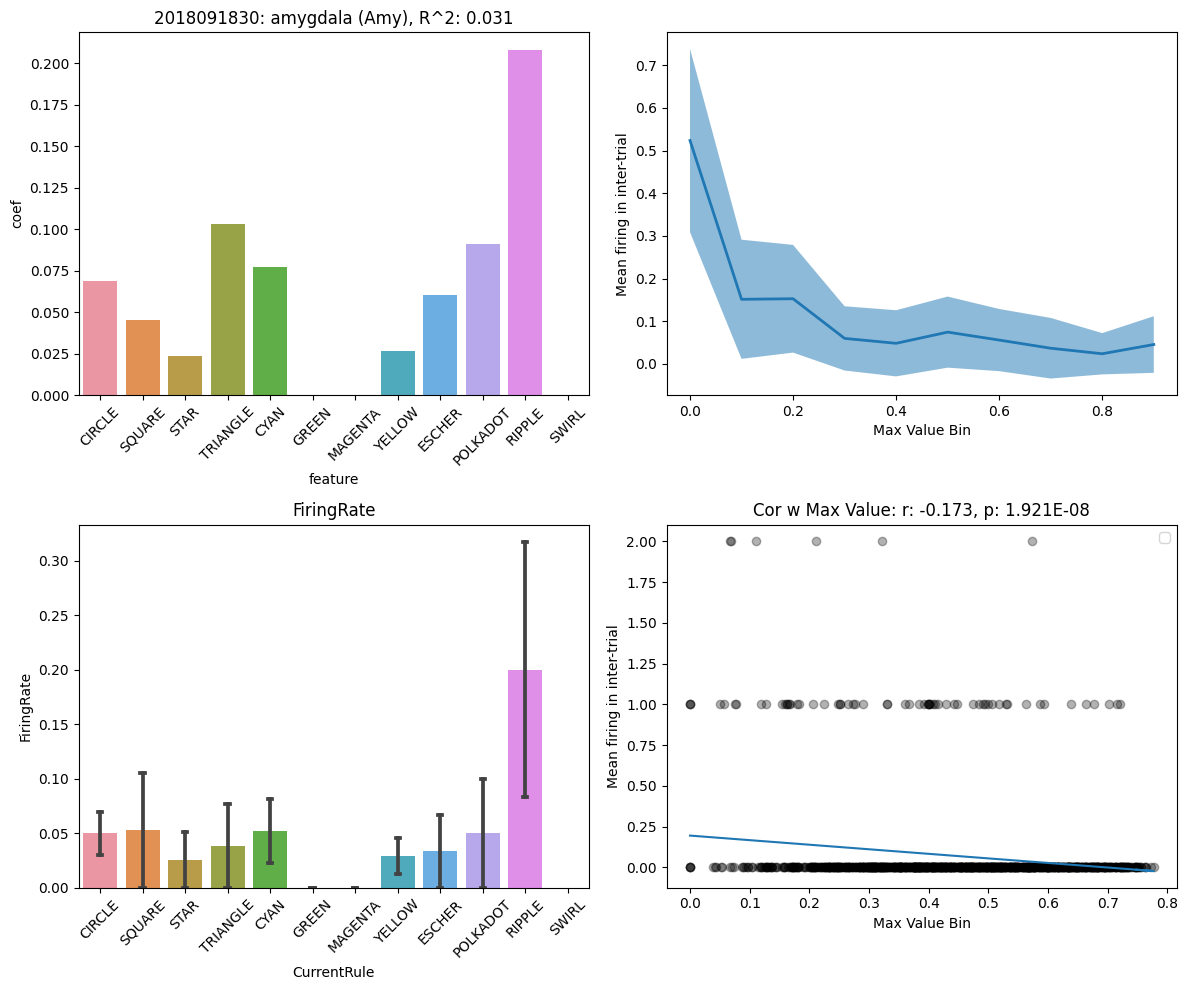

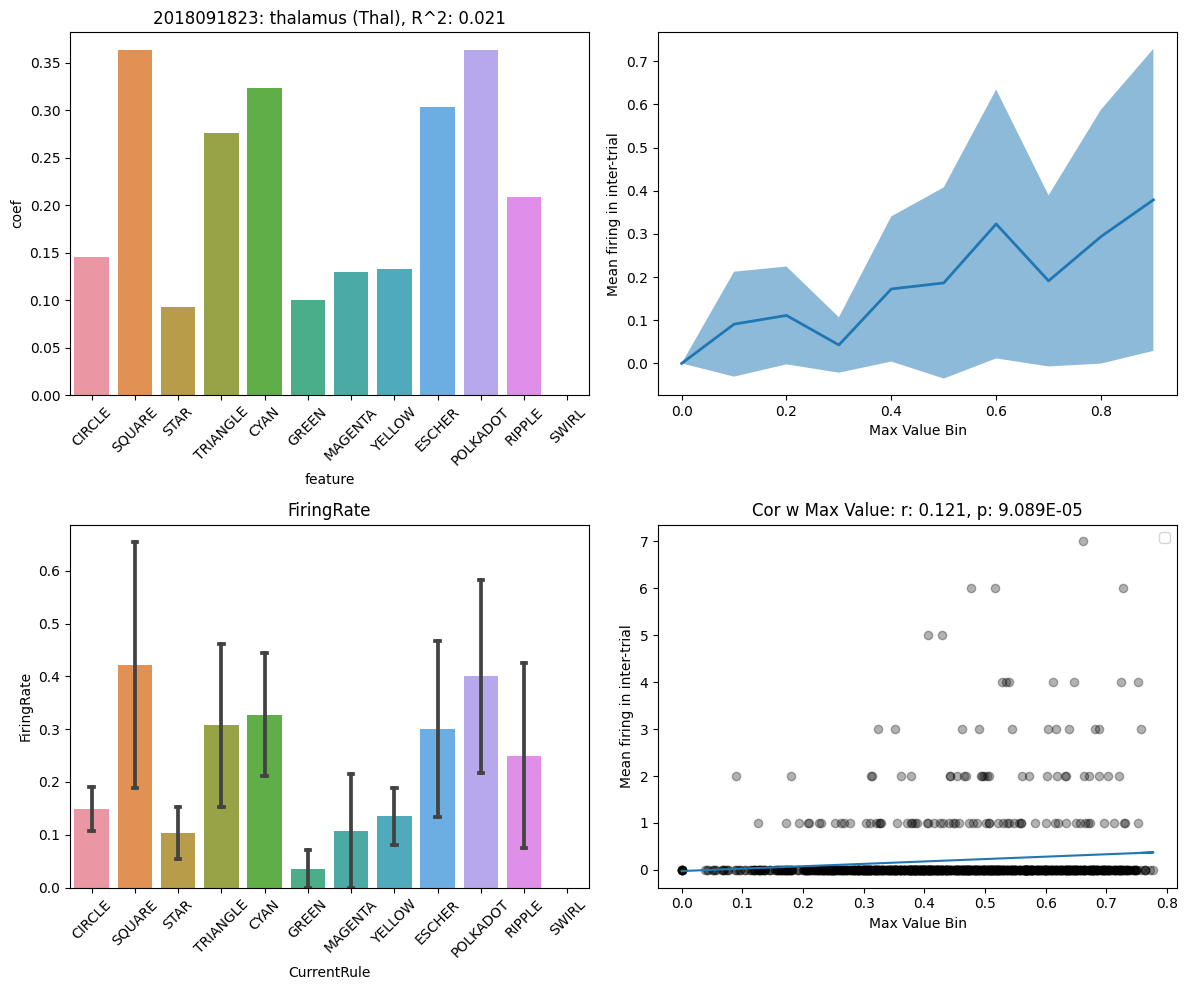

In [12]:
# feats_of_interest = [["MAGENTA", "RIPPLE"], ["POLKADOT", "ESCHER"], ["YELLOW", "ESCHER"], ["CYAN", "SWIRL"], ["MAGENTA", "POLKADOT"]]
# for i, unit in enumerate(good_reses.sort_values(by="score", ascending=False)[:5].PseudoUnitID.unique()):
#     feats = feats_of_interest[i]
#     plot_things(unit, glm_res, mode, feats)
for i, unit in enumerate(good_reses[good_reses.session_x == "20180918"].PseudoUnitID.unique()):
    plot_things(unit, glm_res, mode)

### Try to figure out what's going on with GLM fitting

In [65]:
session = 20180912
unit_id = 4
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)

# filter trials 
beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(beh)
beh = pd.merge(beh, feature_selections, on="TrialNumber")
beh = behavioral_utils.get_feature_values_per_session(session, beh)

fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{NUM_BINS_SMOOTH}_smooth.pickle"
frs = pd.read_pickle(fr_path)
frs = frs[frs.UnitID == unit_id]
agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
# agg = pd.merge(beh[["TrialNumber", "BlockNumber", "MaxFeat"]], agg, on="TrialNumber")
agg = pd.merge(beh[["TrialNumber", "BlockNumber"]], agg, on="TrialNumber")

agg = spike_utils.zscore_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)
agg = spike_utils.mean_sub_frs(agg, group_cols=["UnitID", "BlockNumber"], mode=MODE)

beh = behavioral_utils.filter_blocks_by_rule_occurence(beh, 2)
beh = behavioral_utils.filter_max_feat_correct(beh)

agg = agg[agg.TrialNumber.isin(beh.TrialNumber)]

In [67]:
input_columns = ["MaxFeat"]
columns_to_flatten = ["MaxFeat"]
beh = beh.set_index(["TrialNumber"])
agg = agg.set_index(["TrialNumber"])
all_reses = glm_utils.fit_glm_for_data(
    (beh, agg), 
    input_columns=input_columns, 
    columns_to_flatten=columns_to_flatten,
    mode="MeanSubFiringRate",
    model_type="LinearNoInt",
)

Index(['MaxFeat', 'BlockNumber', 'UnitID', 'TimeBins', 'SpikeCounts',
       'FiringRate', 'ZFiringRate', 'MeanSubFiringRate'],
      dtype='object')
MeanSubFiringRate
MeanSubFiringRate
(457, 7)
(457,)
[-0.09057875  0.07330057 -0.07226375 -0.07739352 -0.26055128 -0.06745858
 -0.15584416]


In [49]:
all_reses

,UnitID,TimeBins,score,RIPPLE_coef,SWIRL_coef,ESCHER_coef,YELLOW_coef,MAGENTA_coef,GREEN_coef,CYAN_coef
0,4,0.475,0.085783,0.242424,1.189189,0.837838,0.671533,0.513889,0.222222,0.793651


In [59]:
input_columns = ["MaxFeat"]
columns_to_flatten = ["MaxFeat"]
not_flattened_columns = [col for col in input_columns if col not in columns_to_flatten]
data, flattened_columns = glm_utils.flatten_columns(agg, columns_to_flatten)
glm_columns = flattened_columns + not_flattened_columns
# res = data.groupby(["UnitID", "TimeBins"]).apply(
#     lambda x: glm_utils.fit_glm(x, glm_columns, mode, model_type, include_predictions, train_test_split)
# ).reset_index()

Index(['TrialNumber', 'BlockNumber', 'MaxFeat', 'UnitID', 'TimeBins',
       'SpikeCounts', 'FiringRate', 'ZFiringRate', 'MeanSubFiringRate'],
      dtype='object')


In [60]:
from sklearn.linear_model import (
    PoissonRegressor,
    LinearRegression,
    Ridge,
)
model = LinearRegression(fit_intercept=False)
ys = data["MeanSubFiringRate"].values
xs = data[glm_columns].values

In [61]:
xs.shape

(457, 7)

<Axes: >

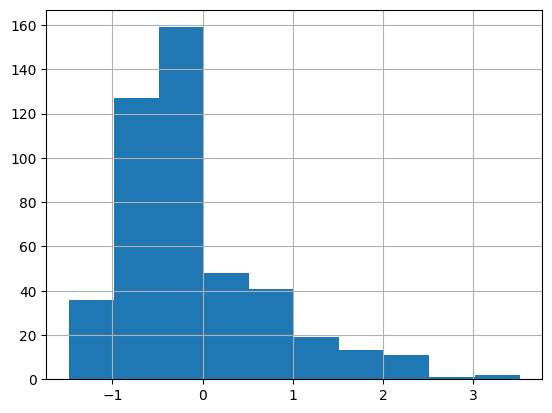

In [25]:
data["MeanSubFiringRate"].hist()

In [63]:
model = model.fit(xs, ys)


In [62]:
ys.shape

(457,)

In [64]:
model.coef_

array([-0.09057875,  0.07330057, -0.07226375, -0.07739352, -0.26055128,
       -0.06745858, -0.15584416])

In [29]:
glm_columns

['RIPPLE', 'SWIRL', 'ESCHER', 'YELLOW', 'MAGENTA', 'GREEN', 'CYAN']

In [36]:
xs.shape

(383, 5)

In [11]:
from numpy.linalg import inv, matrix_rank
# exs = np.hstack((np.ones((383, 1)), xs[:, 1:]))
# exs = np.hstack((np.ones((383, 1)), xs))
exs = xs

beta = inv(exs.T @ exs) @ exs.T @ ys
# beta = inv(xs.T @ xs) @ xs.T @ ys

In [12]:
len(exs[:, 0])

383

In [13]:
beta

array([-0.09057875, -0.07739352, -0.26055128, -0.06745858, -0.15584416])

In [19]:
np.mean(ys[xs[:, 0] == 1])

-0.09057875264270614

In [46]:
-0.09057875 + 0.01318523

-0.07739352

In [8]:
import seaborn as sns
sns.color_palette("husl", 12)

[(0.9677975592919913, 0.44127456009157356, 0.5358103155058701),
 (0.903599057664843, 0.511987276335809, 0.19588350060161624),
 (0.7350228985632719, 0.5952719904750953, 0.1944419133847522),
 (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 (0.3126890019504329, 0.6928754610296064, 0.1923704830330379),
 (0.20312757197899856, 0.6881249249803418, 0.5177618167447304),
 (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 (0.21786710662428366, 0.6656671601322255, 0.7482809385065813),
 (0.23299120924703914, 0.639586552066035, 0.9260706093977744),
 (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 (0.9082572436765556, 0.40195790729656516, 0.9576909250290225),
 (0.9633321742064956, 0.40643825645731757, 0.7592537599568671)]